# TDA Analysis

**Goal:** Compute persistent homology for clean CIFAR-10 features and visualize topological structure

### Overview
In this notebook, we will:
1. Load the clean features (50-dim PCA-reduced)
2. Compute persistence diagrams for H0 (connected components) and H1 (loops)
3. Visualize persistence diagrams
4. Analyze Betti curves
5. Extract topological statistics
6. Save diagrams for later comparison with adversarial features

---

### Why TDA?
Traditional ML looks at distances and gradients in feature space. TDA reveals the shape of the data:
- **H0 (homology dim 0):** Connected components: how clustered is the data?
- **H1 (homology dim 1):** Loops/cycles: are there circular structures?

**Our hypothesis:** Adversarial perturbations will fragment clusters (more H0 features) and **destroy** loops (fewer H1 features).

### Setup and Imports

In [1]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.models.feature_extractor import FeatureExtractor
from src.tda.persistence import compute_persistence, save_diagrams, get_persistence_stats
from src.utils.plotting import plot_persistence_diagram, plot_betti_curve

np.random.seed(111)

print("Successfully imported everything")

Successfully imported everything


### Load Clean Features

We'll use the 50-dimensional PCA-reduced features from `02_feature_extraction.ipynb`. These features were extracted from 45,000 clean CIFAR-10 training images using ResNet50.

In [2]:
data = np.load('../results/features/clean_features_reduced.npz')
clean_features = data['features']
clean_labels = data['labels']

print(f"Clean features shape: {clean_features.shape}")
print(f"Feature range: [{clean_features.min():.4f}, {clean_features.max():.4f}]")
print(f"Labels: {clean_labels.shape}")

Clean features shape: (45000, 50)
Feature range: [-2.4786, 1.6122]
Labels: (45000,)


### Subsample for TDA

Computing persistent homology on 45,000 points is computationally expensive. Therefore, let's use a subset for initial analysis:
- **10,000 samples** for quick experimentation
- Later we can scale up to full dataset if needed

In [3]:
n_samples = 10000
indices = np.random.choice(len(clean_features), n_samples, replace=False)
clean_features_subset = clean_features[indices]
clean_labels_subset = clean_labels[indices]

print(f"\nUsing {n_samples} samples for TDA")
print(f"Subset shape: {clean_features_subset.shape}")


Using 10000 samples for TDA
Subset shape: (10000, 50)


### Compute Persistent Homology

We'll compute:
- **H0:** Connected components (clusters)
- **H1:** 1-dimensional loops (cycles in the data)

This will 1-2 mins:

In [4]:
result_clean = compute_persistence(
    clean_features_subset,
    maxdim=1,
    verbose=True
)

print("\nPersistence computation successfully completed")

Computing persistence for 10000 points in 50D:
Persistence computed
H0 features: 10000
H1 features: 14978

Persistence computation successfully completed


### Extract Persistence Diagrams

The result contains two diagrams:
- `result_clean['dgms'][0]` → H0 diagram (connected components)
- `result_clean['dgms'][1]` → H1 diagram (loops)

Each diagram is an array of (birth, death) pairs. Let's extract the diagrams:

In [5]:
clean_h0 = result_clean['dgms'][0]
clean_h1 = result_clean['dgms'][1]

print(f"H0 diagram: {len(clean_h0)} features")
print(f"H1 diagram: {len(clean_h1)} features")

print("\n--- H0 Statistics (Connected Components) ---")
h0_stats = get_persistence_stats(clean_h0)
print(f"Number of features: {h0_stats['n_features']}")
print(f"Total persistence: {h0_stats['total_persistence']:.4f}")
print(f"Mean persistence: {h0_stats['mean_persistence']:.4f}")
print(f"Max persistence: {h0_stats['max_persistence']:.4f}")

print("\n--- H1 Statistics (Loops) ---")
h1_stats = get_persistence_stats(clean_h1)
print(f"Number of features: {h1_stats['n_features']}")
print(f"Total persistence: {h1_stats['total_persistence']:.4f}")
print(f"Mean persistence: {h1_stats['mean_persistence']:.4f}")
print(f"Max persistence: {h1_stats['max_persistence']:.4f}")

H0 diagram: 10000 features
H1 diagram: 14978 features

--- H0 Statistics (Connected Components) ---
Number of features: 9999
Total persistence: 2831.9765
Mean persistence: 0.2832
Max persistence: 1.1873

--- H1 Statistics (Loops) ---
Number of features: 14978
Total persistence: 161.5036
Mean persistence: 0.0108
Max persistence: 0.0976


### Visualize H0 Persistence Diagram

- Points above the diagonal represent features with longer lifetimes (more persistent).
- Points near the diagonal are noise (born and die quickly).

Saved to ../results/figures/04_persistence_clean_h0.png


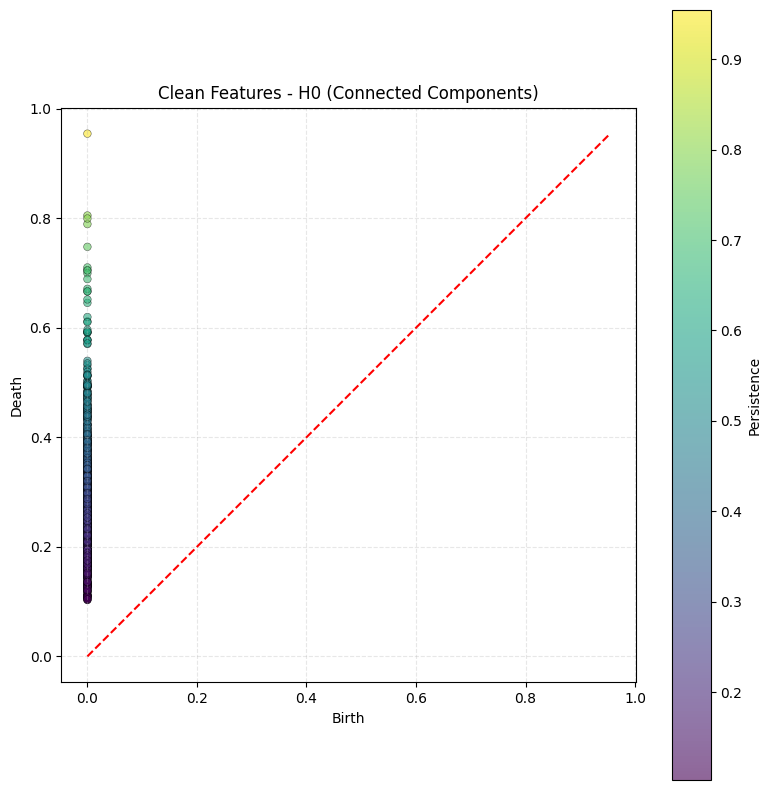

In [6]:
plot_persistence_diagram(
    clean_h0,
    title="Clean Features - H0 (Connected Components)",
    save_path="../results/figures/04_persistence_clean_h0.png"
)

### Visualize H1 Persistence Diagram

- H1 features represent loops/cycles in the feature space.
- They capture non-trivial topological structure.

Saved to ../results/figures/04_persistence_clean_h1.png


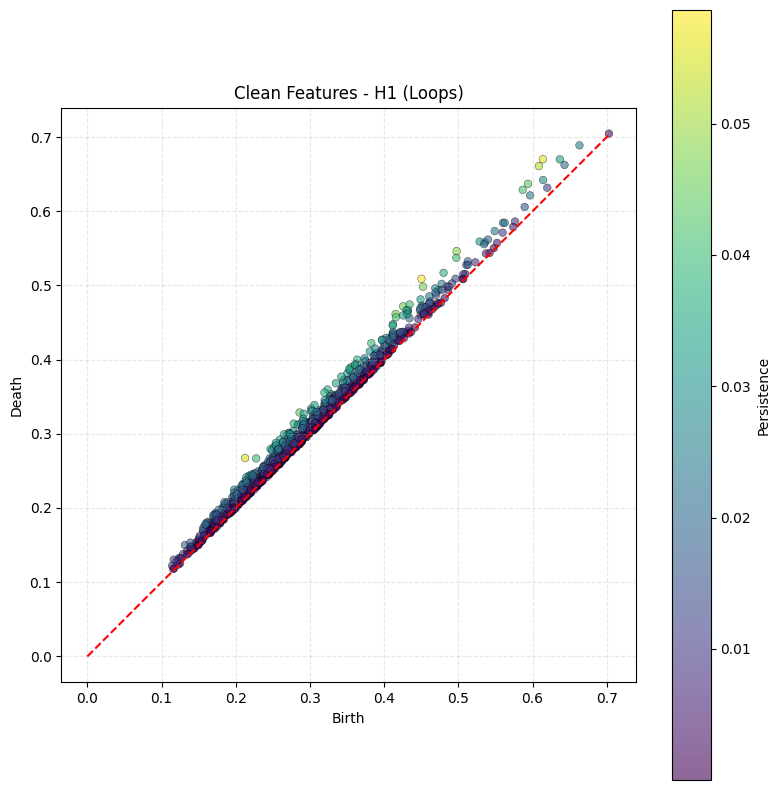

In [7]:
plot_persistence_diagram(
    clean_h1,
    title="Clean Features - H1 (Loops)",
    save_path="../results/figures/04_persistence_clean_h1.png"
)

### Compute Betti Curves

Betti curves show how many topological features are "alive" at each scale.
- x-axis: epsilon (filtration value)
- y-axis: number of features

This gives us a functional representation of topology.

In [8]:
from src.tda.persistence import compute_betti_numbers

epsilons_h0, betti_h0 = compute_betti_numbers(clean_h0)
epsilons_h1, betti_h1 = compute_betti_numbers(clean_h1)

print(f"H0 Betti curve: {len(betti_h0)} points")
print(f"H1 Betti curve: {len(betti_h1)} points")

H0 Betti curve: 100 points
H1 Betti curve: 100 points


Saved to ../results/figures/04_betti_curve_clean_h0.png


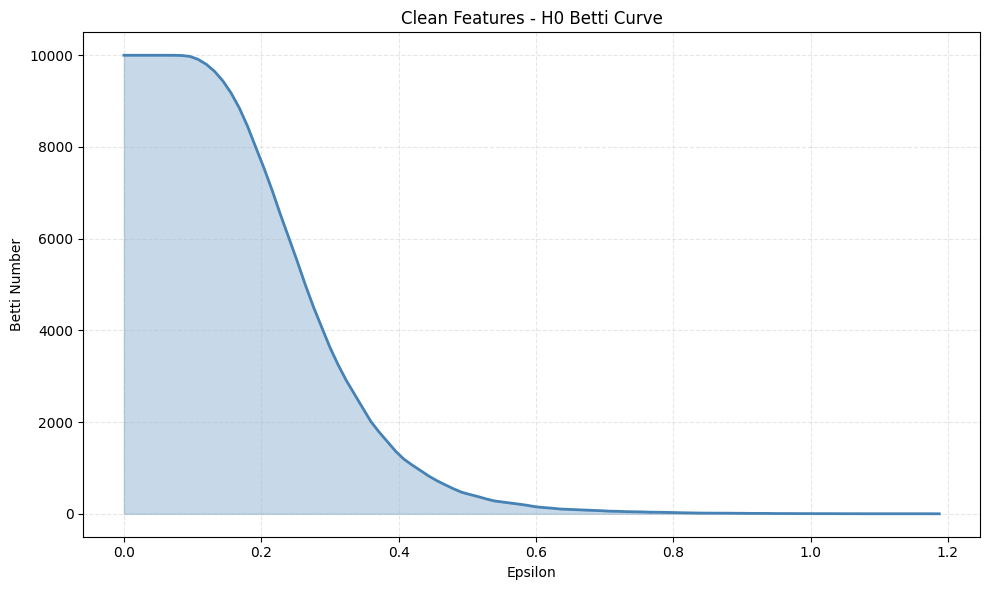

In [9]:
# Plot H0 Betti curve
plot_betti_curve(
    epsilons_h0,
    betti_h0,
    title="Clean Features - H0 Betti Curve",
    save_path="../results/figures/04_betti_curve_clean_h0.png",
    color="steelblue"
)

Saved to ../results/figures/04_betti_curve_clean_h1.png


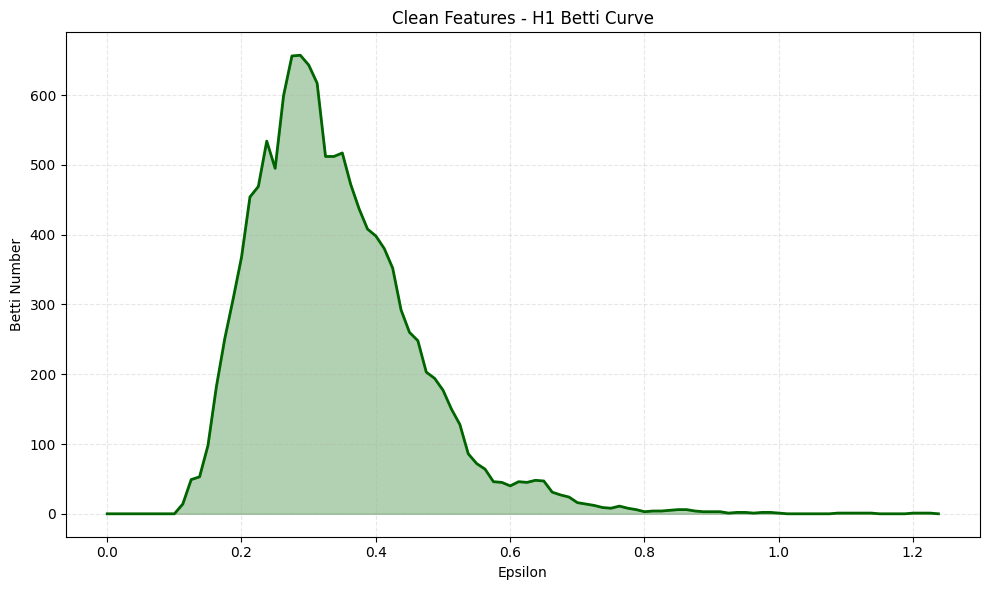

In [10]:
# Plot H1 Betti curve
plot_betti_curve(
    epsilons_h1,
    betti_h1,
    title="Clean Features - H1 Betti Curve",
    save_path="../results/figures/04_betti_curve_clean_h1.png",
    color="darkgreen"
)

### Save Persistence Diagrams

We'll save these diagrams to disk so we can:
1. Load them later for comparison with adversarial features
2. Avoid recomputing (expensive operation)

In [11]:
# Save H0 and H1 diagrams separately
save_diagrams(result_clean, '../results/diagrams/clean_full.pkl')

print("\nDiagrams successfully saved")
print("- clean_full.pkl (contains both H0 and H1)")

Saved diagrams in ../results/diagrams/clean_full.pkl

Diagrams successfully saved
- clean_full.pkl (contains both H0 and H1)


### Visualize Per-Class Topology

Let's see if different CIFAR-10 classes have different topological signatures. We'll compute persistence for a single class (e.g., airplanes):

Class: 0 (airplane)
Number of samples: 1026
Saved to ../results/figures/04_persistence_class_0_h0.png


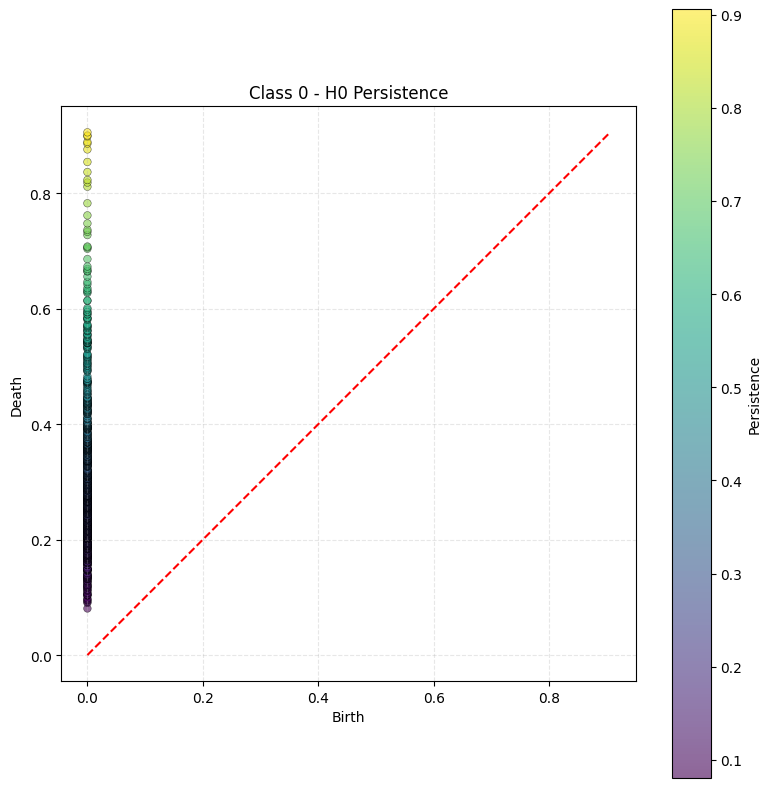

In [12]:
# Extract features for a class, in this case airplanes:
class_idx = 0
class_mask = (clean_labels_subset == class_idx)
class_features = clean_features_subset[class_mask]

print(f"Class: {class_idx} (airplane)")
print(f"Number of samples: {len(class_features)}")

result_class = compute_persistence(class_features[:1000], maxdim=1, verbose=False)
plot_persistence_diagram(
    result_class['dgms'][0],
    title=f"Class {class_idx} - H0 Persistence",
    save_path=f"../results/figures/04_persistence_class_{class_idx}_h0.png"
)

### Summary

We successfully computed persistent homology for clean CIFAR-10 features:

**Generated Files:**
- `clean_full.pkl` - Persistence diagrams (H0, H1)
- `04_persistence_clean_h0.png` - H0 persistence diagram
- `04_persistence_clean_h1.png` - H1 persistence diagram
- `04_betti_curve_clean_h0.png` - H0 Betti curve
- `04_betti_curve_clean_h1.png` - H1 Betti curve

**Key Observations:**
- H0 shows how the data is clustered into connected components
- H1 reveals loop structures in the feature space
- Betti curves provide a functional summary of topology

**Next Steps:**
- Generate FGSM adversarial examples (already done in `03_adversarial_attacks.ipynb`)
- Compute persistence for adversarial features
- Compare clean vs adversarial topology
- Use topological features for detection